<center> <h1> Customer Segmentation in Banking </h1> </center>
<p style="margin-bottom:1cm;"></p>

# Dependencies

In [1]:
%matplotlib inline
%load_ext lab_black

In [2]:
!pip install imblearn --ignore-installed

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\juana_0mrk5mk\\anaconda3\\envs\\MLG\\Lib\\site-packages\\numpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [51]:
from configparser import ConfigParser
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
    f1_score,
    classification_report,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from imblearn.under_sampling import RandomUnderSampler

In [5]:
# to use the seaborn style in the matplotlib plots
plt.style.use("seaborn")

## Data understanding

Load the data and have a look at the basic properties.

In [6]:
parser = ConfigParser()
_ = parser.read("notebook.cfg")

path = parser.get("my_api", "path")

In [8]:
data_path = path + "/Data/banking.csv"

In [9]:
df_raw = pd.read_csv(data_path)
df = df_raw.copy()
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [10]:
# Check the type of values of each column
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

In [11]:
# Check the shape of the DataFrame
df.shape

(41188, 21)

In [12]:
# Check if the df has NaN values
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [13]:
# Some information about each feature
df.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


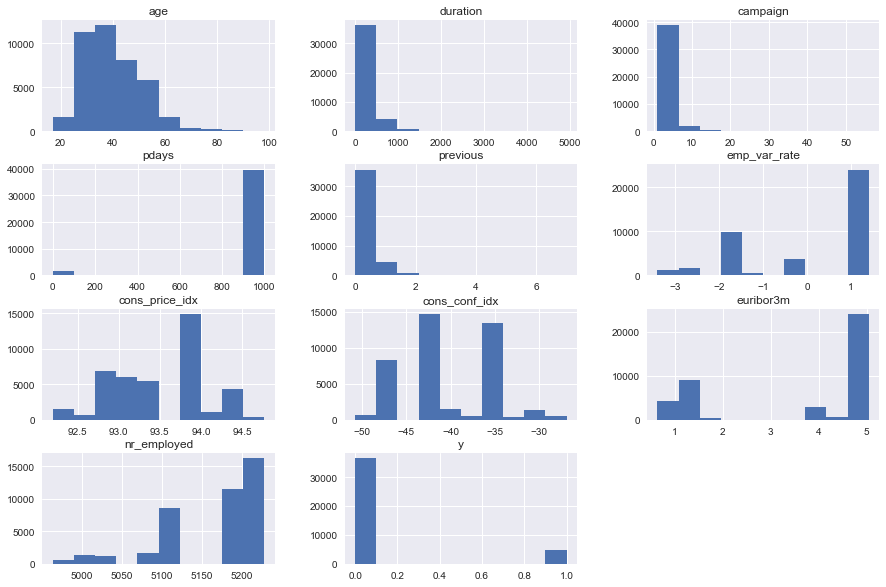

In [14]:
# This creats histograms for all numerical features
df.hist(figsize=(15, 10))
None

In [16]:
# Let's check the number of categories per categorical feature
df.select_dtypes(include=["object"]).apply(lambda col: len(col.unique()))

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

In [17]:
# Take a closer look at features with many categories
print(f"Job categories:\n{df['job'].unique()}\n")
print(f"Month categories:\n{df['month'].unique()}\n")
print(f"Education categories:\n{df['education'].unique()}")

Job categories:
['blue-collar' 'technician' 'management' 'services' 'retired' 'admin.'
 'housemaid' 'unemployed' 'entrepreneur' 'self-employed' 'unknown'
 'student']

Month categories:
['aug' 'nov' 'jun' 'apr' 'jul' 'may' 'oct' 'mar' 'sep' 'dec']

Education categories:
['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate']


In general, the categories look pretty clean. For the education categories we can combine the different levels of basic education to reduce the number of categories.

## Data preprocessing

### Feature extraction 

Don't use the feature 'duration' for building a model since the description of this feature states: 

Last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [18]:
# check the name of the columns
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [19]:
# get features and corresponding outcomes
df_clean = df.drop(columns=["duration"])
df_clean

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1,0
41184,31,housemaid,married,basic.4y,unknown,no,no,telephone,may,thu,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,2,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,0


### Train-Test Split

We separate the dataset into train and test as follows in order to perform sampling later.   
Taking sample from the whole dataset (with 'y' included) is easier than taking it separately from X_train and y_train.  

In [25]:
X = df_clean.iloc[:, :-1]
y = df_clean["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=19
)

### Split numerical and categorical features
For data preprocessing we have to separate numerical and categorical features. Different preprocessing steps are required for both type of features.

In [27]:
categorical_features = df_clean.iloc[:, list(np.where(X.dtypes == "object")[0])].columns
numerical_features = df_clean.iloc[:, list(np.where(X.dtypes != "object")[0])].columns
categorical_features, numerical_features

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'day_of_week', 'poutcome'],
       dtype='object'),
 Index(['age', 'campaign', 'pdays', 'previous', 'emp_var_rate',
        'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
       dtype='object'))

### Scaling and encoding using a scikit-learn pipeline

Here we show how to apply different preprocessing and feature extraction pipelines for the case of dataset that contain heterogeneous data types, since we may want to **scale** the numeric features and **one-hot encode** the categorical ones.

Finally, the preprocessing pipeline is integrated in a full prediction pipeline using sklearn.pipeline.Pipeline, together with the specific ml model.

In [28]:
# The numeric data is standard-scaled
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# while the categorical data is one-hot encoded
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

# The column transformer allows to apply different preprocessing steps for individual sets of columns
# transformers must support fit and transform.
# Special-cased strings ‘drop’ and ‘passthrough’ are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Logistic Regression

Let's compare how Logistic Regression with no penalty, L1 and L2 penalties works

### No penalty 

In [29]:
# We use in this case solver = 'lbfgs' because it works for no penalty Logistic Regression
model_0 = LogisticRegression(
    class_weight="balanced", solver="lbfgs", penalty="none", max_iter=1000
)

#  implement pipeline
pipeline_nopenality = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model_0)]
)

In [30]:
# check the cross validation score
n_samples = 1000
sample_train = df_train.sample(n_samples, random_state=42)

lr_nopenalty_score_f1 = np.mean(
    cross_val_score(
        pipeline_nopenality,
        sample_train.drop(columns="y"),
        sample_train["y"],
        cv=4,
        scoring="f1",
    )
)

lr_nopenalty_score_f1

0.2728216225363928

In [31]:
# We are going to apply different alpha values to the L1 and L2 penalties
# That's why we have to define it firstly
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

score_df_f1 = pd.DataFrame()
score_df_f1["alpha"] = alphas

### L1 Cross-Validation

In [32]:
model_l1 = LogisticRegression(
    class_weight="balanced", penalty="l1", solver="liblinear", max_iter=1000
)
pipeline_l1 = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model_l1)])

In [33]:
scores_l1 = []
for alpha in alphas:
    pipeline_l1.set_params(classifier__C=1 / alpha)
    score = np.mean(
        cross_val_score(
            pipeline_l1,
            sample_train.drop(columns="y"),
            sample_train["y"],
            cv=4,
            scoring="f1",
        )
    )
    scores_l1.append(score)
score_df_f1["L1"] = scores_l1

### L2 Cross-Validation

In [34]:
model_l2 = LogisticRegression(class_weight="balanced", penalty="l2", solver="liblinear")
pipeline_l2 = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model_l2)])

In [35]:
scores_l2 = []
for alpha in alphas:
    pipeline_l2.set_params(classifier__C=1 / alpha)
    score = np.mean(
        cross_val_score(
            pipeline_l2,
            sample_train.drop(columns="y"),
            sample_train["y"],
            cv=4,
            scoring="f1",
        )
    )
    scores_l2.append(score)
score_df_f1["L2"] = scores_l2

In [36]:
score_df_f1

,alpha,L1,L2
0,0.0001,0.272822,0.279154
1,0.0010,0.277946,0.279154
2,0.0100,0.280397,0.280397
3,0.1000,0.293031,0.300153
4,1.0000,0.316877,0.324070
5,10.0000,0.338030,0.365932
6,100.0000,0.321749,0.354086
7,1000.0000,0.000000,0.319409


In [37]:
score_df_f1.describe()

,alpha,L1,L2
count,8.000000,8.000000,8.000000
mean,138.888888,0.262606,0.312794
std,349.648809,0.108678,0.034168
min,0.000100,0.000000,0.279154
25%,0.007750,0.276665,0.280086
50%,0.550000,0.286714,0.309781
75%,32.500000,0.318095,0.331574
max,1000.000000,0.338030,0.365932


Select the best model by comparing 'f1' score.
You can also try different scoring parameter

Text(0, 0.5, 'f1 score')

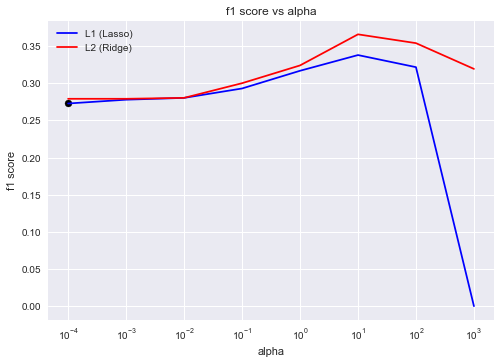

In [38]:
# Lasso
plt.semilogx(score_df_f1["alpha"], score_df_f1["L1"], color="blue", label="L1 (Lasso)")

# Ridge
plt.semilogx(score_df_f1["alpha"], score_df_f1["L2"], color="red", label="L2 (Ridge)")
plt.scatter(x=alphas[0], y=lr_nopenalty_score_f1, color="black")
plt.title("f1 score vs alpha")
plt.xlabel("alpha")
plt.legend()
plt.ylabel("f1 score")

Let's find out the maximum score and the best penalty

In [39]:
score_df_f1.L1.max(), score_df_f1.L2.max(), lr_nopenalty_score_f1

(0.3380297079481704, 0.3659320428511863, 0.2728216225363928)

Another way to check for the best score

In [40]:
score_df_f1.iloc[[score_df_f1.drop(columns=["alpha"]).stack().idxmax()[0]]]

,alpha,L1,L2
5,10.0,0.33803,0.365932


In [41]:
best_alpha = score_df_f1.iloc[
    [score_df_f1.drop(columns=["alpha"]).stack().idxmax()[0]]
].alpha.values[0]
best_penalty = [score_df_f1.drop(columns=["alpha"]).stack().idxmax()][0][1]
print("The best alpha and penalty are {} and {}".format(best_alpha, best_penalty))

The best alpha and penalty are 10.0 and L2


Other way to check for the worst score

In [42]:
score_df_f1.iloc[[score_df_f1.drop(columns=["alpha"]).stack().idxmin()[0]]]

,alpha,L1,L2
7,1000.0,0.0,0.319409


In [43]:
worst_alpha = score_df_f1.iloc[
    [score_df_f1.drop(columns=["alpha"]).stack().idxmin()[0]]
].alpha.values[0]
worst_penalty = [score_df_f1.drop(columns=["alpha"]).stack().idxmin()][0][1]
print(f"The worst alpha and penalty are {worst_alpha} and {worst_penalty}")

The worst alpha and penalty are 1000.0 and L1


As we can see, the nopenalty score is not the best and not the worst

## Modeling with the best selected model

### The Best model

In [44]:
X_train = sample_train.drop(columns="y")
y_train = sample_train["y"]

X_test = df_test.drop(columns="y")
y_test = df_test["y"]

In [45]:
print(f"Reminder: The best alpha and penalty are {best_alpha} and {best_penalty}")

Reminder: The best alpha and penalty are 10.0 and L2


In [46]:
pipeline_best_model = pipeline_l1.set_params(
    classifier__C=1 / best_alpha, classifier__penalty=best_penalty.lower()
)

# fit and view model parameters
pipeline_best_model.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balan

Predictions with the best model

In [47]:
predictions_train = pipeline_best_model.predict_proba(X_train)[:, 1]
predictions_test = pipeline_best_model.predict_proba(X_test)[:, 1]
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, predictions_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, predictions_test)

### The Worst model

In [48]:
# worst score was with L1 regularization and alpha = 1000

pipeline_worst_model = pipeline_l1.set_params(
    classifier__C=1 / worst_alpha, classifier__penalty=worst_penalty.lower()
)

# fit and view model parameters
pipeline_worst_model.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(C=0.001, class_weight='bal

Predictions with the worst model

In [49]:
predictions_train_untuned = pipeline_worst_model.predict_proba(X_train)[:, 1]
predictions_test_untuned = pipeline_worst_model.predict_proba(X_test)[:, 1]
fpr_train_untuned, tpr_train_untuned, _ = metrics.roc_curve(
    y_train, predictions_train_untuned
)
fpr_test_untuned, tpr_test_untuned, _ = metrics.roc_curve(
    y_test, predictions_test_untuned
)

## Plotting

A ROC curve is considered to be good if it is closer to the top left corner, and the straight line connecting (0,0) and (1,1) represents a random classier with even odds.

The advantage of using ROC is that one can visually see for what region a model is more superior compare to another.

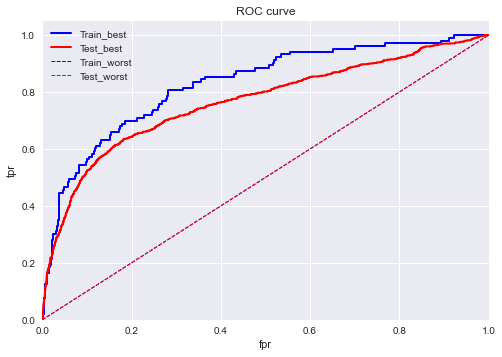

In [50]:
plt.plot(fpr_train, tpr_train, "b", linewidth=2, markersize=4, label="Train_best")
plt.plot(fpr_test, tpr_test, "r", linewidth=2, markersize=4, label="Test_best")
plt.plot(
    fpr_train_untuned,
    tpr_train_untuned,
    "b--",
    linewidth=1,
    markersize=4,
    label="Train_worst",
)
plt.plot(
    fpr_test_untuned,
    tpr_test_untuned,
    "r--",
    linewidth=1,
    markersize=4,
    label="Test_worst",
)
plt.xlabel("fpr")
plt.legend()
plt.ylabel("tpr")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("ROC curve")
None

__KNN__

In [ ]:
scores = []

knn = KNeighborsClassifier()
knn

KNeighborsClassifier()

In [ ]:
pipeline_knn = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", knn)])

In [ ]:
pipeline_knn.fit(X_train_rus, y_train_rus)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object'))])),
                ('estimator', KNeighborsClassifier())])

In [ ]:
pred_knn = pipeline_knn.predict(X_test)
scores.append(f1_score(y_test, pred_knn))


In [ ]:
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      7292
           1       0.38      0.75      0.50       946

    accuracy                           0.83      8238
   macro avg       0.67      0.80      0.70      8238
weighted avg       0.90      0.83      0.85      8238



__Naive Bayes__

In [ ]:
nb = BernoulliNB()

pipeline_nb = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", nb)])


In [ ]:

pipeline_nb.fit(X_train_rus, y_train_rus)

pred_nb = pipeline_nb.predict(X_test)
scores.append(f1_score(y_test, pred_nb))

In [ ]:
print(classification_report(y_test, pred_nb))

              precision    recall  f1-score   support

           0       0.96      0.81      0.87      7292
           1       0.32      0.71      0.44       946

    accuracy                           0.80      8238
   macro avg       0.64      0.76      0.66      8238
weighted avg       0.88      0.80      0.83      8238



__SVM__

In [ ]:
svm = LinearSVC()

pipeline_svm = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", svm)])

In [ ]:

pipeline_svm.fit(X_train_rus, y_train_rus)

pred_svm = pipeline_svm.predict(X_test)
scores.append(f1_score(y_test, pred_svm))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      7292
           1       0.44      0.82      0.57       946

    accuracy                           0.86      8238
   macro avg       0.70      0.84      0.74      8238
weighted avg       0.91      0.86      0.87      8238



__RandomForestClassifier__

In [ ]:
rfc = RandomForestClassifier(n_estimators=500, random_state=42)

pipeline_rfc = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", rfc)])

In [ ]:
pipeline_rfc.fit(X_train_rus, y_train_rus)

pred_rfc = pipeline_rfc.predict(X_test)
scores.append(f1_score(y_test, pred_rfc))

In [ ]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.99      0.84      0.90      7292
           1       0.42      0.90      0.57       946

    accuracy                           0.84      8238
   macro avg       0.70      0.87      0.74      8238
weighted avg       0.92      0.84      0.87      8238



__AdaBoost__

In [ ]:
ada = AdaBoostClassifier()

pipeline_ada = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", ada)])

In [ ]:

pipeline_ada.fit(X_train_rus, y_train_rus)

pred_ada = pipeline_ada.predict(X_test)
scores.append(f1_score(y_test, pred_ada))

In [ ]:
print(classification_report(y_test, pred_ada))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7292
           1       0.41      0.82      0.55       946

    accuracy                           0.84      8238
   macro avg       0.69      0.83      0.73      8238
weighted avg       0.91      0.84      0.86      8238



In [ ]:
ada2 = AdaBoostClassifier(n_estimators=100,
                          base_estimator=DecisionTreeClassifier(max_depth=8, 
                                                                random_state=42), 
                          random_state=42)
pipeline_ada2 = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", ada2)])
pipeline_ada2.fit(X_train_rus, y_train_rus)
pred_ada = pipeline_ada2.predict(X_test)
print(classification_report(y_test, pred_ada))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      7292
           1       0.38      0.85      0.53       946

    accuracy                           0.83      8238
   macro avg       0.68      0.84      0.71      8238
weighted avg       0.91      0.83      0.85      8238



__XGBoost__

In [ ]:
xgb = XGBClassifier()

pipeline_xgb = Pipeline([("col_transformer", preprocessor), 
                            ("estimator", xgb)])

In [ ]:

pipeline_xgb.fit(X_train_rus, y_train_rus)

pred_xgb = pipeline_xgb.predict(X_test)
scores.append(f1_score(y_test, pred_xgb))

In [ ]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7292
           1       0.42      0.88      0.56       946

    accuracy                           0.84      8238
   macro avg       0.70      0.86      0.73      8238
weighted avg       0.92      0.84      0.87      8238



### Compare model performance

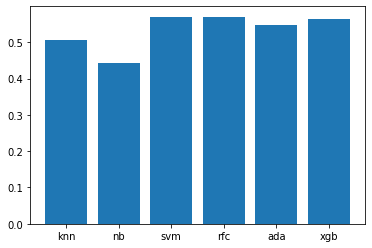

In [ ]:
models = ["knn", "nb", "svm", "rfc","ada","xgb"]
plt.bar(models, scores);

In [ ]:
models

['knn', 'nb', 'svm', 'rfc', 'ada', 'xgb']

In [ ]:
scores

[0.504805980776077,
 0.44407786209171896,
 0.5685986793837124,
 0.570286475682878,
 0.547635850388144,
 0.5644504748982361]

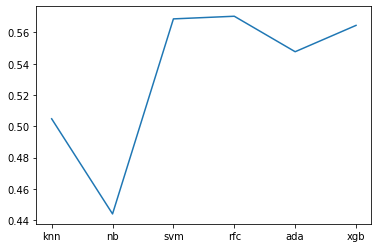

In [ ]:
plt.plot(models,scores);

### Feature Importance 

Trees based models like RandomForest, XGBoost, etc.  provide us feature importance based on the training.

In [ ]:
pipeline_rfc

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object'))])),
                ('estimator',
                 RandomForestClassifier(n_estimators=500, random_state=42))])

In [ ]:
rfc_model = pipeline_rfc['estimator']
rfc_model

RandomForestClassifier(n_estimators=500, random_state=42)

In [ ]:
pipeline_rfc['col_transformer'].transformers_

[('num',
  Pipeline(steps=[('scaler', StandardScaler())]),
  Index(['age', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')),
 ('cat',
  Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]),
  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
         'month', 'day_of_week', 'poutcome'],
        dtype='object')),
 ('remainder', 'drop', [15, 16, 17, 18, 19])]

In [ ]:
num_feat = list(pipeline_rfc['col_transformer'].transformers_[0][2])
cat_feat = list(pipeline_rfc['col_transformer'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))

In [ ]:
feature_columns = num_feat+cat_feat
feature_columns

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_basic.4y',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'default_no',
 'default_unknown',
 'housing_no',
 'housing_unknown',
 'housing_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_fri',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'day_of_week_wed',
 'poutcome_failure',
 'pou

In [ ]:
rfc_model.feature_importances_

array([8.68824664e-02, 3.55761320e-01, 3.97206822e-02, 3.30589997e-02,
       1.86403734e-02, 1.06862701e-02, 9.30979657e-03, 3.82869422e-03,
       3.13232592e-03, 6.16254764e-03, 6.71773012e-03, 4.32718460e-03,
       6.88706261e-03, 6.66226931e-03, 9.18551378e-03, 3.46264440e-03,
       1.45786869e-03, 6.52966347e-03, 1.05220434e-02, 1.04457053e-02,
       1.66006530e-04, 6.00374008e-03, 3.71951074e-03, 7.48790246e-03,
       1.01542545e-02, 2.36888416e-04, 7.61321264e-03, 1.15848625e-02,
       4.42889467e-03, 8.90891832e-03, 9.20058076e-03, 1.18576310e-02,
       1.93160090e-03, 1.17709180e-02, 8.30132479e-03, 1.82778314e-03,
       7.74647173e-03, 1.73785437e-02, 1.65391812e-02, 1.30534719e-02,
       9.84519026e-03, 2.47463396e-03, 1.12941986e-02, 1.49733947e-02,
       1.70960932e-02, 1.77349446e-02, 1.02005515e-02, 1.23535621e-02,
       7.38583953e-03, 1.09061125e-02, 1.15538963e-02, 1.13907568e-02,
       1.07021752e-02, 1.06513216e-02, 6.30671849e-03, 1.62226745e-02,
      

In [ ]:
rfc_importances = pd.DataFrame(
    {"feature": feature_columns, "importance": np.round(rfc.feature_importances_, 3)}
)
rfc_importances = rfc_importances.sort_values("importance", ascending=False).set_index(
    "feature"
)
rfc_importances

,importance
feature,
duration,0.356
age,0.087
campaign,0.040
pdays,0.033
poutcome_success,0.026
previous,0.019
month_may,0.018
month_mar,0.017
contact_telephone,0.017


In [ ]:
# rfc_importances

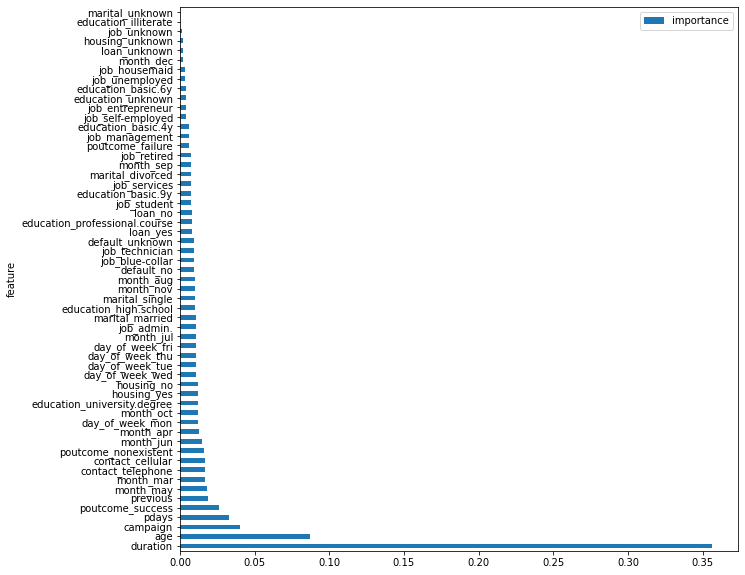

In [ ]:
f,ax = plt.subplots(figsize=(10,10)) 
rfc_importances.plot(kind="barh",ax=ax);